In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

import fields
import model
import prediction
import plot

%matplotlib inline

In [3]:
ds = xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc")
ds = ds.where(ds.time.dt.year > 2014, drop=True)

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]

datasets = [ds_xco2, ds_sif]
covariates = [["lon", "lat"], ["evi"]]
timedeltas = [0, -1]
vario_config = fields.VarioConfig(1500, 30)

In [4]:
mf = fields.MultiField(
        datasets, covariates, np.datetime64("2016-08-01"), timedeltas
    )
gamma = mf.empirical_variograms(vario_config)

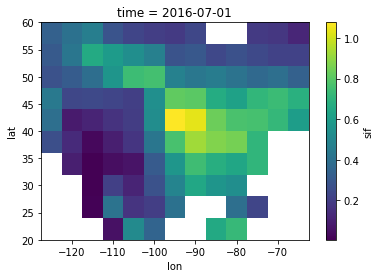

In [5]:
from data_utils import get_main_coords
ds_show = get_main_coords(ds_sif.sif.sel(time="2016-07-01"))
ds_show.sif.T.plot()

## Fitting
---

In [6]:
mod = model.FullBivariateMatern()
mod.fit(gamma)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.022804,"(0.4, 3.5)"
1,sigma_22,1.111082,"(0.4, 3.5)"
2,nu_11,0.761062,"(0.2, 3.5)"
3,nu_12,3.500000,"(0.2, 3.5)"
4,nu_22,0.865863,"(0.2, 3.5)"
5,len_scale_11,366.394072,"(100.0, 2000.0)"
6,len_scale_12,2000.000000,"(100.0, 2000.0)"
7,len_scale_22,665.881210,"(100.0, 2000.0)"
8,nugget_11,0.057784,"(0.0, 0.2)"
9,nugget_22,0.025702,"(0.0, 0.2)"


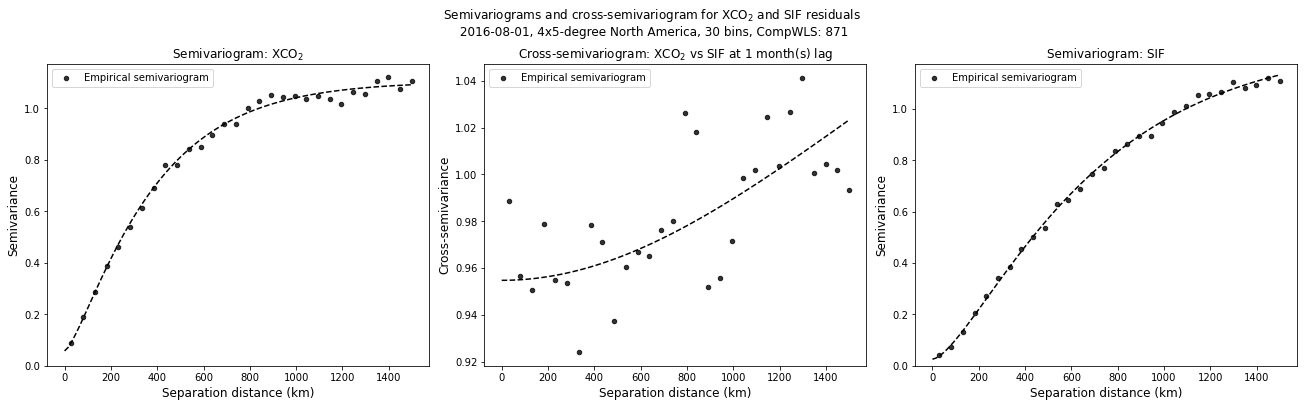

In [7]:
plot.plot_variograms(mod.fit_result, ["XCO$_2$", "SIF"])

## Prediction
---

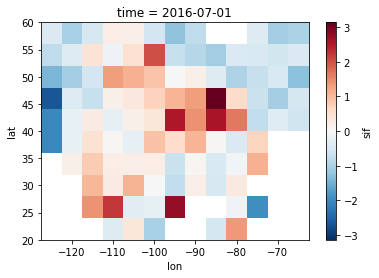

In [8]:
mf.fields[1].ds_main[mf.fields[1].data_name].T.plot()

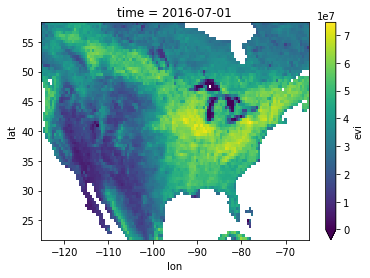

In [10]:
da_evi = xr.open_dataarray("../data/exp_pro/MODIS_05deg_monthly_conus.nc")
da_evi.sel(time="2016-07-01").T.plot(vmin=0)

In [26]:
pcoords = prediction.prediction_coords()
P = prediction.Predictor(mod, mf, covariates=da_evi)
ds_pred = P(1, pcoords, max_dist=1e3)
ds_pred

<xarray.Dataset>
Dimensions:     (lon: 121, lat: 73)
Coordinates:
  * lon         (lon) float64 -125.0 -124.5 -124.0 -123.5 ... -66.0 -65.5 -65.0
  * lat         (lat) float64 22.0 22.5 23.0 23.5 24.0 ... 56.5 57.0 57.5 58.0
    time        datetime64[ns] 2016-07-01
Data variables:
    pred        (lon, lat) float64 nan nan nan nan ... 0.2932 0.2401 0.1372
    pred_err    (lon, lat) float64 nan nan nan nan ... 0.06893 0.05992 0.04986
    covariates  (lon, lat) float32 nan nan nan ... 3.31e+07 3.002e+07 2.363e+07

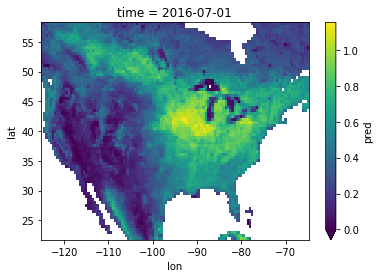

In [27]:
ds_pred["pred"].T.plot(vmin=0)

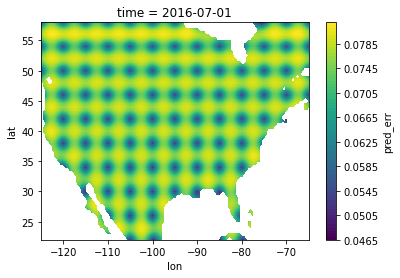

In [28]:
xr.plot.contourf(ds_pred["pred_err"].T, levels=75)

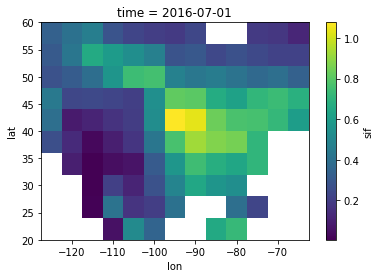

In [29]:
ds_show.sif.T.plot()